# Manipulation of CMIP6 model data using Pangeo catalog

Pangeo maintains an experimental catalog of analysis-ready cloud-based data at catalog.pangeo.io.

Our project is actively researching different approaches to storing and cataloging data in the cloud. Some important technologies currently in use include:

Spatiotemporal Asset Catalog: A common language to describe a range of geospatial information, so it can more easily be indexed and discovered.

Intake: A python package for finding, investigating, loading and disseminating data.

http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/
https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q/edit

list of all models: https://docs.google.com/spreadsheets/d/13DHeTEH_8G08vxTMX1Fs-WbAA6SamBjDdh0fextdcGE/edit#gid=165882553



In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
#conda install -c conda-forge zarr
import zarr #Zarr is a format for the storage of chunked, compressed, N-dimensional arrays.
import fsspec

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
print(df.columns)

Index(['activity_id', 'institution_id', 'source_id', 'experiment_id',
       'member_id', 'table_id', 'variable_id', 'grid_label', 'zstore',
       'dcpp_init_year', 'version'],
      dtype='object')


#table id for aerosols
- AERday : Daily atmospheric chemistry and aerosol data
- AERfx : Fixed atmospheric chemistry and aerosol data 
- AERhr : Hourly atmospheric chemistry and aerosol data 
- AERmon : Monthly atmospheric chemistry and aerosol data 
- AERmonZ : Monthly atmospheric chemistry and aerosol data 

variables (https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271)

- chepasoa	Total Net Production of Anthropogenic Secondary Organic Aerosol [kg m-2 s-1]	AERmon
- chepsoa	Chemical Production of Dry Aerosol Secondary Organic Matter [kg m-2 s-1]	AERmon
- conccmcn	Number Concentration Coarse Mode Aerosol [m-3]	Emon
- conccn	Aerosol Number Concentration [m-3]	Emon
- concdust	Concentration of Dust [kg m-3]	Emon
- concnmcn	Number Concentration of Nucleation Mode Aerosol [m-3]	Emon
- drybc	Dry Deposition Rate of Black Carbon Aerosol Mass [kg m-2 s-1]	AERmon
- dryoa	Dry Deposition Rate of Dry Aerosol Total Organic Matter [kg m-2 s-1]	AERmon
- dryss	Dry Deposition Rate of sea-salt aerosol [kg m-2 s-1]	AERmon
- ec550aer	Aerosol Extinction Coefficient [m-1]	6hrLev, Emon
- emiaoa	Total Emission Rate of Anthropogenic Organic Aerosol [kg m-2 s-1]	AERmon
- emibc	Total Emission Rate of Black Carbon Aerosol Mass [kg m-2 s-1]	AERmon
- emioa	Primary Emission and Chemical Production of Dry Aerosol Organic Matter [kg m-2 s-1]	AERmon
- emiss	Total Emission Rate of sea-salt aerosol [kg m-2 s-1]	AERmon
- loadoa	Load of Dry Aerosol Organic Matter [kg m-2]	Eday
- loadpoa	Load of Dry Aerosol Primary Organic Matter [kg m-2]	Eday
- loadsoa	Load of Dry Aerosol Secondary Organic Matter [kg m-2]	Eday
- loadss	Load of Sea-Salt Aerosol [kg m-2]	Emon
- lwsffluxaero	Longwave flux due to volcanic aerosols at the surface [W m-2]	6hrPlevPt
- lwtoacsaer	TOA Clear-Sky longwave Radiative Forcing due to Aerosols [W m-2]	Emon
- lwtoafluxaerocs	TOA Outgoing Clear-Sky Longwave Flux Due to Volcanic Aerosols [W m-2]	6hrPlevPt
- mmraerh2o	Aerosol Water Mass Mixing Ratio [kg kg-1]	AERmon
- mmrdust	Dust Aerosol Mass Mixing Ratio [kg kg-1]	AERmon
- mmrno3	NO3 Aerosol Mass Mixing Ratio [kg kg-1]	AERmon, Emon
- mmroa	Total Organic Aerosol Mass Mixing Ratio [kg kg-1]	AERmon
- mmrso4	Aerosol Sulfate Mass Mixing Ratio [kg kg-1]	AERmon
- mmrsoa	Secondary Organic Aerosol Mass Mixing Ratio [kg kg-1]	AERmon
- mmrss	sea-salt aerosol Mass Mixing Ratio [kg kg-1]	AERmon, Emon

In [3]:
variables_list = list(df['variable_id'].unique())
#print(variables_list) 
#print(variables_list.index("conccmcn")) 

Most of the datasets available are stored in cloud-friendly formats like zarr and are meant to be opened with xarray. Though there is no standard catalog format, our catalogs currently rely upon Intake and Intake-esm.

In [4]:
df_Emon = df.query("activity_id=='CMIP' & table_id == 'Emon'")
print(df_Emon['variable_id'].unique())

['orog' 'evspsblpot' 'mrsol' 'co23D' 'co2s' 'cLand' 'concdust' 'utendnogw'
 'sconcss' 'sconcso4' 'sconcdust' 'rhLut' 'raLut' 'utendogw' 'nppLut'
 'loadss' 'loadso4' 'loaddust' 'nep' 'vegFrac' 'vtendnogw' 'vegHeight'
 'gppLut' 'laiLut' 'vtendogw' 'cSoil' 'treeFracBdlDcd' 'treeFracBdlEvg'
 'treeFracNdlEvg' 'ps' 'tntscp' 'tntrscs' 'tntrlcs' 'tntpbl' 'tnhusscp'
 'tnhuspbl' 'clwmodis' 'cltmodis' 'clmisr' 'climodis' 'parasolRefl'
 'clcalipsoice' 'clcalipsoliq' 'prhmax' 'hcont300' 'ua' 'va' 'rsdsdiff'
 'rsdscsdiff' 'tasminCrop' 'tasmaxCrop' 'ta' 'zg' 'mrroLut' 'mrlso'
 'tasLut' 'fracLut' 'hflsLut' 'hfssLut' 'hussLut' 'sfcWindmax' 'mrsfl'
 'tslsiLut' 'mrsll' 'mrsoLut' 'netAtmosLandCO2Flux' 'rls' 'rlusLut' 'rss'
 'rsusLut' 'mrsosLut']


In [5]:
df_AERmon = df.query("activity_id=='CMIP' & table_id == 'AERmon' & experiment_id == 'historical'")
print(df_AERmon['variable_id'].unique())

['emidust' 'emiss' 'mmrbc' 'mmrdust' 'mmroa' 'mmrpm2p5' 'o3' 'mmrsoa'
 'mmrss' 'od550lt1aer' 'oh' 'emidms' 'mmrso4' 'cltc' 'ptp' 'airmass'
 'cdnc' 'ua' 'toz' 'so2' 'rsutcsaf' 'wa' 'rlutcsaf' 'rlutaf' 'va'
 'od870aer' 'od550aer' 'abs550aer' 'rsutaf' 'ps' 'dms' 'zg' 'ttop' 'cod'
 'co' 'co2' 'no' 'no2' 'o3prod' 'ch4' 'o3loss' 'mmrnh4' 'lossco' 'lwp'
 'photo1d' 'lossch4' 'emilnox' 'tropoz' 'emibvoc' 'c2h6' 'c3h8' 'dryso4'
 'dryss' 'emibc' 'emico' 'dryso2' 'c3h6' 'bldep' 'eminh3' 'eminox'
 'drynh4' 'drynh3' 'drybc' 'emioa' 'emiso2' 'emiisop' 'hcl' 'dryoa'
 'drynoy' 'ch3coch3' 'cheaqpso4' 'chegpso4' 'chepsoa' 'dryo3' 'drydust'
 'aoanh' 'od550oa' 'od550no3' 'od550dust' 'od550bc' 'od440aer' 'o3ste'
 'nh50' 'n2o' 'jno2' 'lossn2o' 'od550so4' 'isop' 'pan' 'reffclwtop'
 'wetso4' 'tatp' 'tntrl' 'tntrs' 'hcho' 'hno3' 'mmrno3' 'mmrpm1' 'mmrpm10'
 'od550soa' 'od550ss' 'wetdust' 'wetnh3' 'wetnh4' 'wetnoy' 'wetoa'
 'wetso2' 'wetss' 'ztp' 'wetbc' 'pfull']


In [6]:
#df_conccn = df.query("'variable_id' == 'concnmcn'")

# Search and Load CMIP6 Data via ESGF / OPeNDAP

In [7]:
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = []
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    return sorted(all_files)

In [8]:
result = esgf_search(activity_id='CMIP', variable_id='conccn', experiment_id='historical',)
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=conccn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=conccn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=conccn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=conccn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=conccn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=40
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMI

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r1i1p1f2/Emon/conccn/gn/v20190823/conccn_Emon_MIROC-ES2L_historical_r1i1p1f2_gn_185001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r2i1p1f2/Emon/conccn/gn/v20190823/conccn_Emon_MIROC-ES2L_historical_r2i1p1f2_gn_185001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r3i1p1f2/Emon/conccn/gn/v20190823/conccn_Emon_MIROC-ES2L_historical_r3i1p1f2_gn_185001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/conccn/gn/v20190627/conccn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-189912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/conccn/gn/v20190627/conccn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_190001-194912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOH

In [9]:
result = esgf_search(activity_id='CMIP', variable_id='dms', experiment_id='historical',)
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=40
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=d

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=450
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=460
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=470
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=480
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=490
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variabl

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=900
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=910
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=920
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=930
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=940
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variabl

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1340
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1350
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1360
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1370
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1380
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&va

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1780
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1790
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1800
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1810
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=dms&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=1820
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&va

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/BCC/BCC-ESM1/historical/r1i1p1f1/AERmon/dms/gn/v20190812/dms_AERmon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/BCC/BCC-ESM1/historical/r2i1p1f1/AERmon/dms/gn/v20190812/dms_AERmon_BCC-ESM1_historical_r2i1p1f1_gn_185001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/BCC/BCC-ESM1/historical/r3i1p1f1/AERmon/dms/gn/v20190812/dms_AERmon_BCC-ESM1_historical_r3i1p1f1_gn_185001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r1i1p1f2/AERmon/dms/gn/v20190823/dms_AERmon_MIROC-ES2L_historical_r1i1p1f2_gn_185001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r2i1p1f2/AERmon/dms/gn/v20190823/dms_AERmon_MIROC-ES2L_historical_r2i1p1f2_gn_185001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MIROC/MIROC-ES2L/historical/r3i1p

In [10]:
result = esgf_search(activity_id='CMIP', variable_id='concnmcn', experiment_id='historical',)
result

https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=concnmcn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=0
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=concnmcn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=10
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=concnmcn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=20
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=concnmcn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=30
https://esgf-node.llnl.gov/esg-search/search/?activity_id=CMIP&variable_id=concnmcn&experiment_id=historical&project=CMIP6&type=File&distrib=false&format=application%2Fsolr%2Bjson&offset=40
https://esgf-node.llnl.gov/esg-search/search/?activ

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/concnmcn/gn/v20190406/concnmcn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-189912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/concnmcn/gn/v20190406/concnmcn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_190001-194912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/concnmcn/gn/v20190406/concnmcn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-199912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/concnmcn/gn/v20190406/concnmcn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r2i1p1f2/Emon/concnmcn/gn/v20190502/concnmcn_Emon_UKESM1-0-LL_historical_r2i1p1f2_gn_185001-189912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/cs

In [11]:
# there are mulitple sources of the same data--need to pick one
files_to_open = result[:4]
ds = xr.open_mfdataset(files_to_open, combine='by_coords') #Open multiple files as a single dataset. and #combine
ds

C:\Users\DominicHeslinRees\Anaconda3\lib\site-packages\dask\array\core.py:1519: RuntimeWarning: overflow encountered in long_scalars
  cbytes = format_bytes(np.prod(self.chunksize) * self.dtype.itemsize)


<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lev: 85, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lev        (lev) float64 20.0 53.33 100.0 ... 7.378e+04 7.91e+04 8.5e+04
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object dask.array<chunksize=(600, 2), meta=np.ndarray>
    lev_bnds   (time, lev, bnds) float64 dask.array<chunksize=(600, 85, 2), meta=np.ndarray>
    b          (time, lev) float64 dask.array<chunksize=(600, 85), meta=np.ndarray>
    b_bnds     (time, lev, bnds) float64 dask.array<chunksize=(600, 85, 2), meta=np.ndarray>
    lat_bnds   (time, lat, bnds) float64 dask.array<chunksize=(600, 144, 2), meta=np.ndarray>
    lon_bnds   (time, lon, bnds) float64 dask.array<chunksize=(600, 192, 2), meta=np.ndarray>
    orog       (time, lat, lon) float32 dask.array<chunksize=(600, 144, 192), meta=np.ndarray>
    concnmcn   (time, lev, lat, lon) float32 dask.array<chunksize=(600, 85, 144, 192), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           144000.0
    creation_date:                   2019-04-05T15:51:40Z
    ...                              ...
    variable_id:                     concnmcn
    variant_label:                   r1i1p1f2
    license:                         CMIP6 model data produced by the Met Off...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/0bcfc894-ec0a-4426-87f6-2c0...
    DODS_EXTRA.Unlimited_Dimension:  time

(array([2.293355e+06, 3.579500e+04, 1.124700e+04, 4.360000e+03,
        2.533000e+03, 1.624000e+03, 7.330000e+02, 2.510000e+02,
        1.240000e+02, 5.800000e+01]),
 array([0.0000000e+00, 4.1913247e+09, 8.3826493e+09, 1.2573974e+10,
        1.6765299e+10, 2.0956623e+10, 2.5147947e+10, 2.9339271e+10,
        3.3530597e+10, 3.7721919e+10, 4.1913246e+10], dtype=float32),
 <BarContainer object of 10 artists>)

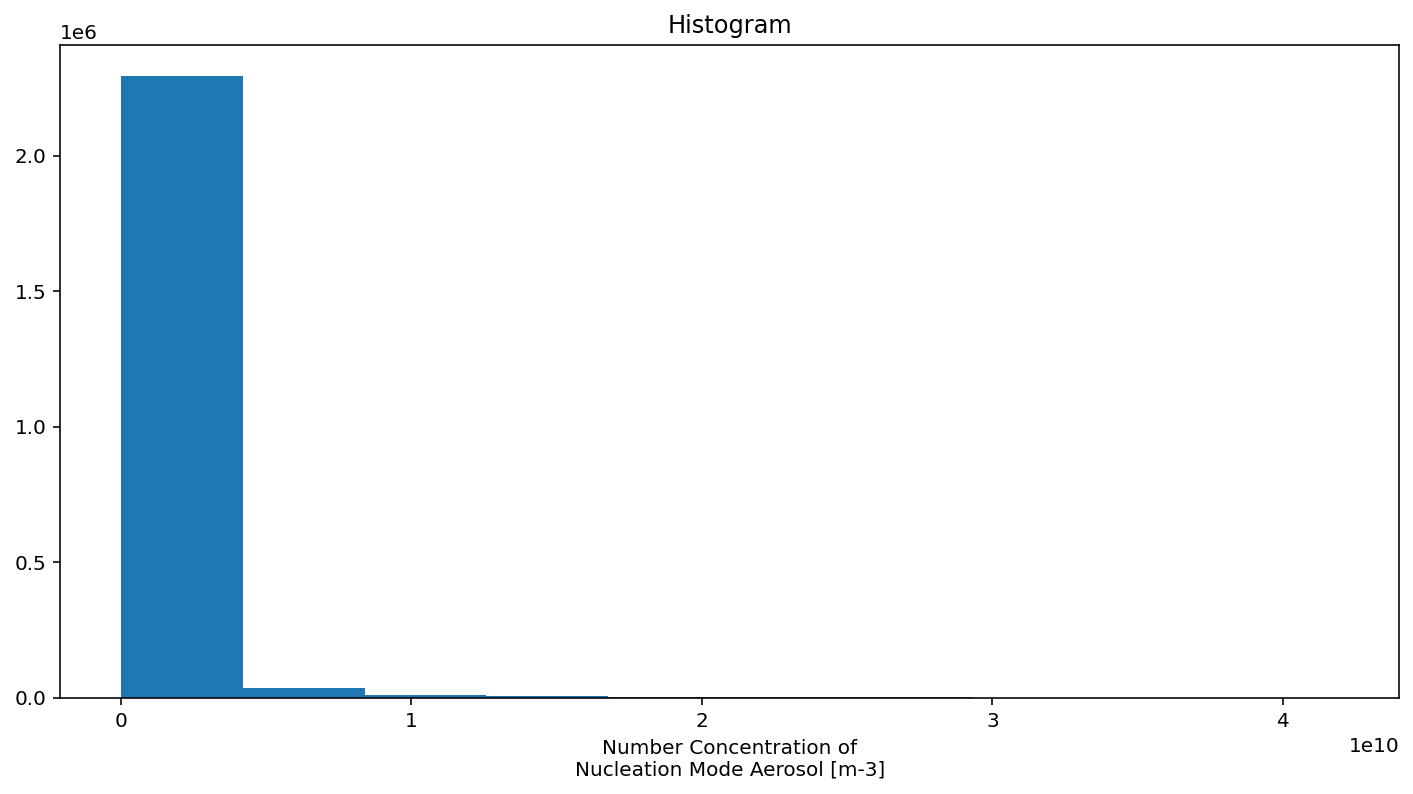

In [12]:
ds.concnmcn.sel(time='1950-01').squeeze().plot()

In [13]:
result

['http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/concnmcn/gn/v20190406/concnmcn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_185001-189912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/concnmcn/gn/v20190406/concnmcn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_190001-194912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/concnmcn/gn/v20190406/concnmcn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_195001-199912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/Emon/concnmcn/gn/v20190406/concnmcn_Emon_UKESM1-0-LL_historical_r1i1p1f2_gn_200001-201412.nc',
 'http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r2i1p1f2/Emon/concnmcn/gn/v20190502/concnmcn_Emon_UKESM1-0-LL_historical_r2i1p1f2_gn_185001-189912.nc',
 'http://aims3.llnl.gov/thredds/dodsC/cs

In [14]:
ds = xr.open_dataset(result[3]) #Open and decode a dataset from a file or file-like object.
ds

<xarray.Dataset>
Dimensions:    (time: 180, bnds: 2, lev: 85, lat: 144, lon: 192)
Coordinates:
  * time       (time) object 2000-01-16 00:00:00 ... 2014-12-16 00:00:00
  * lev        (lev) float64 20.0 53.33 100.0 ... 7.378e+04 7.91e+04 8.5e+04
  * lat        (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon        (lon) float64 0.9375 2.812 4.688 6.562 ... 355.3 357.2 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lev_bnds   (lev, bnds) float64 ...
    b          (lev) float64 ...
    b_bnds     (lev, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    orog       (lat, lon) float32 ...
    concnmcn   (time, lev, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                     CF-1.7 CMIP-6.2
    activity_id:                     CMIP
    branch_method:                   standard
    branch_time_in_child:            0.0
    branch_time_in_parent:           144000.0
    creation_date:                   2019-04-05T17:47:09Z
    ...                              ...
    variable_id:                     concnmcn
    variant_label:                   r1i1p1f2
    license:                         CMIP6 model data produced by the Met Off...
    cmor_version:                    3.4.0
    tracking_id:                     hdl:21.14100/730654e2-bd3e-4027-8bd0-c33...
    DODS_EXTRA.Unlimited_Dimension:  time

In [15]:
concnmcn_2000 = ds.concnmcn.sel(time='2000-01-16')
concnmcn_2000_lev20 = concnmcn_2000.sel(lev=20, method="nearest")

In [16]:
concnmcn_2000_lev20

<xarray.DataArray 'concnmcn' (time: 1, lat: 144, lon: 192)>
array([[[1303873.8 , 1344850.2 , ..., 1281736.9 , 1269882.9 ],
        [ 798851.25,  811603.4 , ...,  831449.1 ,  822152.3 ],
        ...,
        [  92951.51,  102015.  , ...,   78087.56,   84107.72],
        [  43237.01,   42992.05, ...,   42913.84,   43338.59]]], dtype=float32)
Coordinates:
  * time     (time) object 2000-01-16 00:00:00
    lev      float64 20.0
  * lat      (lat) float64 -89.38 -88.12 -86.88 -85.62 ... 86.88 88.12 89.38
  * lon      (lon) float64 0.9375 2.812 4.688 6.562 ... 353.4 355.3 357.2 359.1
Attributes:
    standard_name:  number_concentration_of_nucleation_mode_ambient_aerosol_p...
    long_name:      Number Concentration of Nucleation Mode Aerosol
    comment:        mo: Geometric mean diameter less than 10 nm., CMIP_table_...
    units:          m-3
    original_name:  mo: (stash: m01s38i504, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-04-05T17:47:09Z altered by CMOR: replaced missing va...
    _ChunkSizes:    [ 1 43 72 96]

In [17]:
# concnmcn = concnmcn_2000_lev20.plot(subplot_kws=dict(projection=ccrs.Orthographic(-80, 35), facecolor="gray"),
#     transform=ccrs.PlateCarree(),)
# concnmcn.axes.set_global()
# concnmcn.axes.coastlines()

In [18]:
import matplotlib.path as mpath
import cartopy as cy
import matplotlib.ticker as ticker
import cartopy.crs as ccrs

def polarCentral_set_latlim(lat_lims, ax):
    ax.set_extent([-180, 180, lat_lims[0], lat_lims[1]], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
def add_map_features(ax):
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl = ax.gridlines(draw_labels=True, linewidth=1)    
    gl.top_labels = True
    gl.right_labels = True
    
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)

def create_projections_dict(ZEP_lat, ZEP_lon):
    dict_projections = {}    
    geo = ccrs.Geodetic(); dict_projections['geo'] = geo
    rotated_pole = ccrs.RotatedPole(pole_latitude=ZEP_lat, pole_longitude=ZEP_lon)
    dict_projections['rotated_pole'] = rotated_pole
    North_Stereo = ccrs.NorthPolarStereo() 
    dict_projections['North_Stereo'] = North_Stereo
    ortho = ccrs.Orthographic(central_longitude=ZEP_lon, central_latitude=ZEP_lat)
    dict_projections['ortho'] = ortho
    Nearside = ccrs.NearsidePerspective(central_longitude=ZEP_lon, central_latitude=ZEP_lat, satellite_height=35785831, false_easting=0, false_northing=0, globe=None)
    dict_projections['Nearside'] = Nearside
    PlateCarree = ccrs.PlateCarree()
    dict_projections['PlateCarree'] = PlateCarree
    rotated_pole = ccrs.RotatedPole(pole_latitude=ZEP_lat, pole_longitude=ZEP_lon)  
    dict_projections['rotated_pole'] = rotated_pole    
    return dict_projections 

In [19]:
def produce_spatial_plot(xrray, ax=None):
    dict_projections = create_projections_dict(ZEP_lat=78.906,ZEP_lon=11.888)
    North_Stereo = dict_projections['North_Stereo']  

    fig, ax = sp_map(1, projection=North_Stereo, figsize=(10,10))
    lat_lims = [60,90]
    polarCentral_set_latlim(lat_lims, ax)
    add_map_features(ax)
    
    xrray.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=10**9, cmap='GnBu')
    
    fmt = ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    ax.gridlines(draw_labels=True)
    ax.coastlines()

    plt.show()
    
    if ax is None:
        return fig
    if ax is not None:
        print("return ax")
        return ax

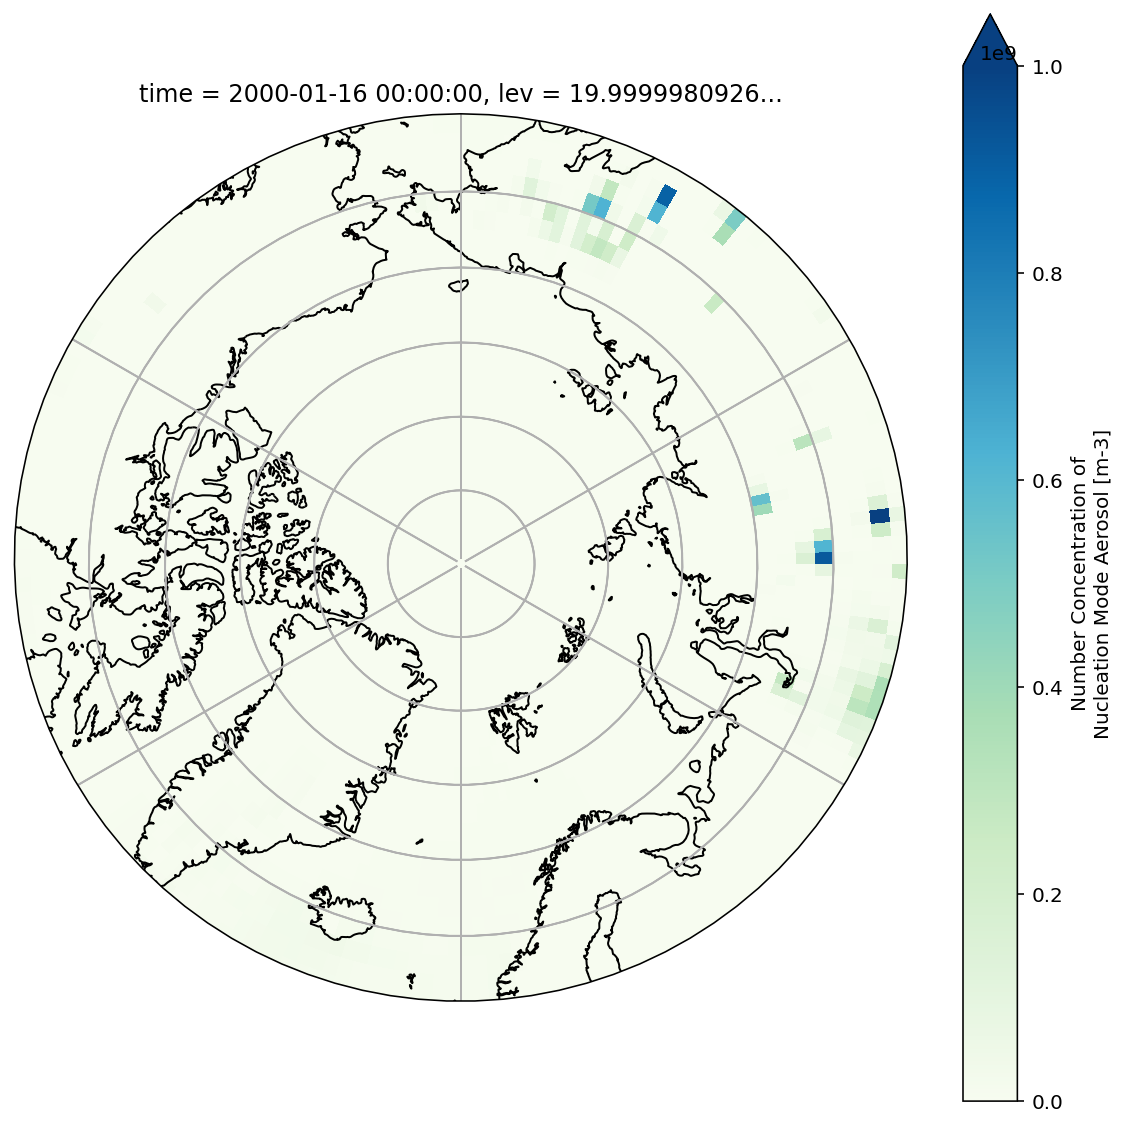

return ax


In [20]:
fig = produce_spatial_plot(concnmcn_2000_lev20, ax=None)

In [21]:
def produce_spatial_ax_plot(xrray, ax=None):
    lat_lims = [60,90]
    polarCentral_set_latlim(lat_lims, ax)
    add_map_features(ax)
    
    xrray.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=0, vmax=10**9, cmap='GnBu')

    fmt = ticker.ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((0, 0))
    ax.gridlines(draw_labels=True)
    ax.coastlines()
    return ax

In [22]:
concnmcn_2000 = ds.concnmcn.sel(time='2000-01-16')
concnmcn_2000_lev20 = concnmcn_2000.sel(lev=20, method="nearest")

months=['01','02','03','04','05','06','07','08','09','10','11','12']
nrows=4

import math

def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier

def append_months(year, lev=20,
                  months=['01','02','03','04','05','06','07','08','09','10','11','12']):
    list_concnmcn = []
    for month in months:
        concnmcn = ds.concnmcn.sel(time=str(year)+'-'+str(month)+'-16')        
        concnmcn = concnmcn.sel(lev=20, method="nearest")
        list_concnmcn.append(concnmcn)
    return list_concnmcn   
  
list_concnmcn = append_months(2000)

def subplots(list_concnmcn):
    dict_projections = create_projections_dict(ZEP_lat=78.906, ZEP_lon=11.888)                  
    projection = dict_projections['North_Stereo']

    number_of_months = len(months)
    ncols = int(round_up(number_of_months/nrows))
    print("num cols: "+str(ncols))

    fig, axs = sp_map(nrows, ncols, projection=projection, figsize=(8*ncols,8*nrows))   
    axs=axs.flatten()

    for i,month in enumerate(list_concnmcn):
        produce_spatial_ax_plot(month, ax=axs[i])

    plt.show()
    return fig

num cols: 3


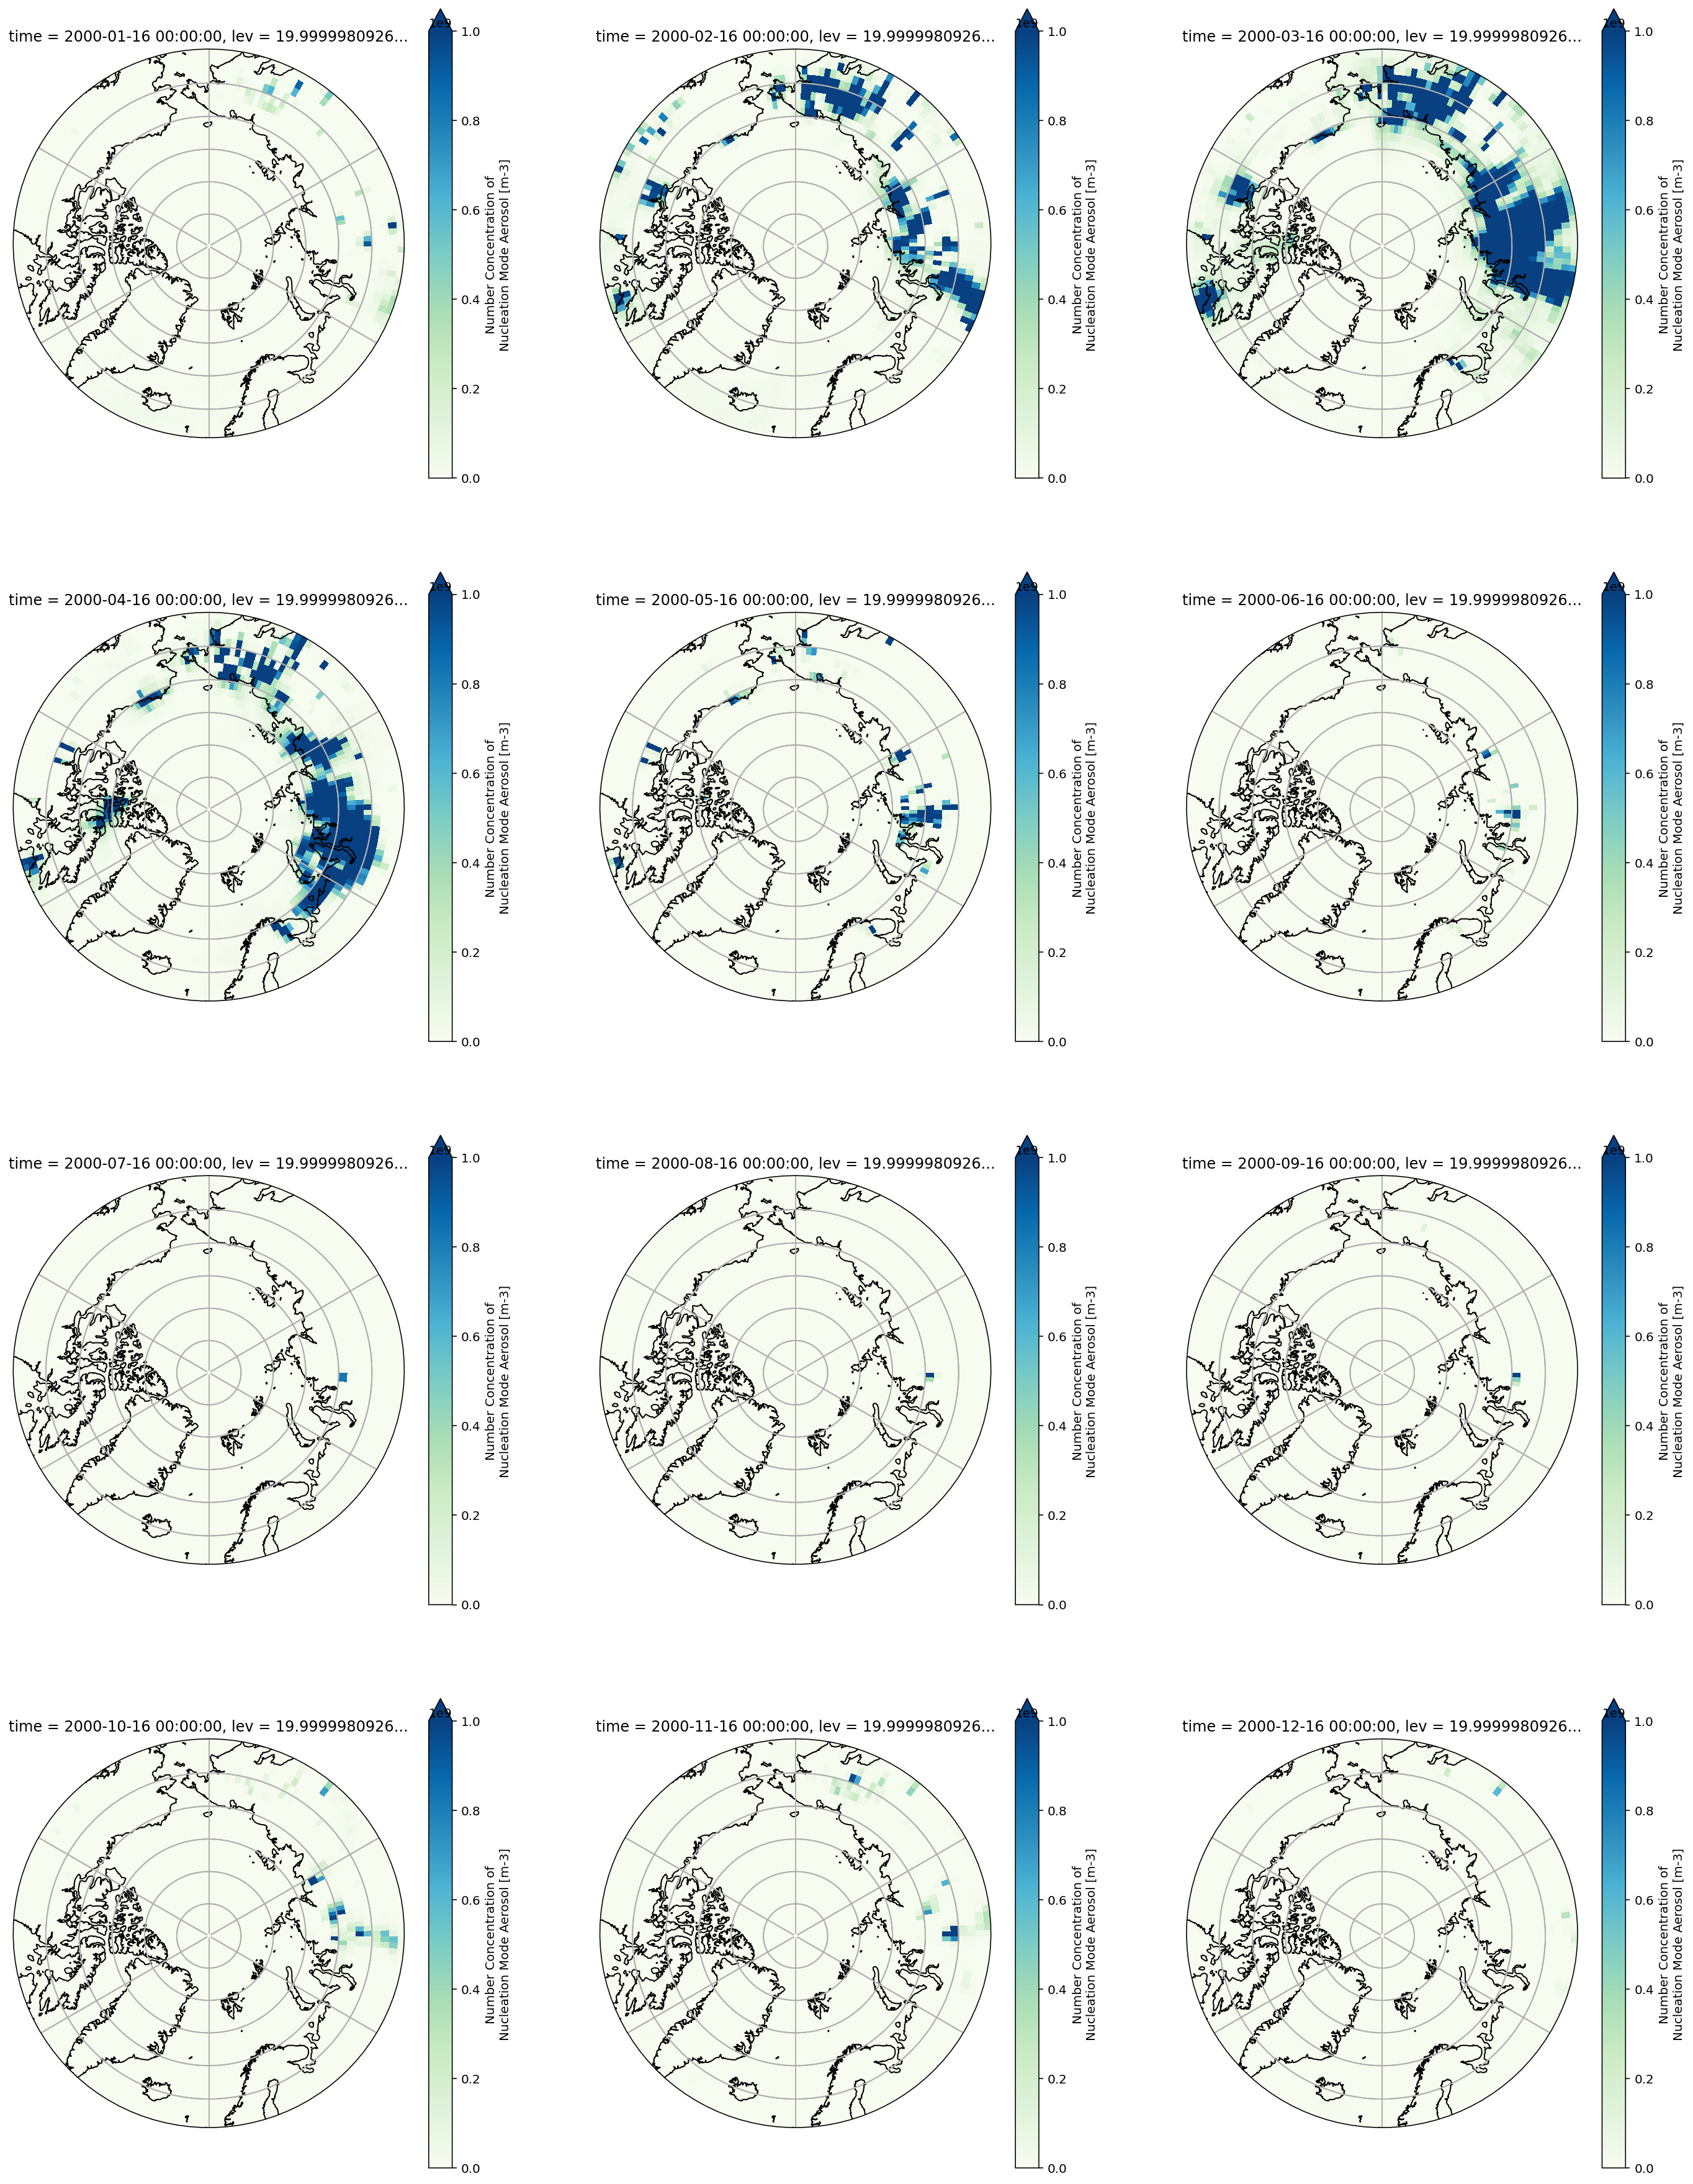

In [23]:
list_concnmcn = append_months(2000, lev=20)

fig = subplots(list_concnmcn)